In [1]:
using Revise

In [2]:
using LazySets
using ModelVerification

In [3]:
using PyCall
using CSV
using ONNX
using Flux
using DataFrames

In [4]:
include("vnnlib_parser.jl")

read_vnnlib_simple (generic function with 1 method)

In [5]:

function onnx_to_nnet(onnx_file)
    pushfirst!(PyVector(pyimport("sys")."path"), dirname(dirname(@__FILE__)))
    nnet = pyimport("NNet")
    use_gz = split(onnx_file, ".")[end] == "gz"
    if use_gz
        onnx_file = onnx_file[1:end-3]
    end
    nnet_file = onnx_file[1:end-4] * "nnet"
    isfile(nnet_file) && return
    nnet.onnx2nnet(onnx_file, nnetFile=nnet_file)
end

function verify_an_instance(onnx_file, spec_file, timeout)
    use_gz = split(onnx_file, ".")[end] == "gz"
    nnet_file = use_gz ? onnx_file[1:end-7] * "nnet" : onnx_file[1:end-4] * "nnet"
    net = ModelVerification.read_nnet(nnet_file)
    ###### TODO: change this ad-hoc remedy for nnet read ######
    net.layers[1] = ModelVerification.Layer(net.layers[1].weights, net.layers[1].bias, ModelVerification.Id())
    flux_model = Flux.Chain(net)
    n_in = size(net.layers[1].weights)[2]
    n_out = length(net.layers[end].bias)
    specs = read_vnnlib_simple(spec_file, n_in, n_out)
    current_time = 0
    for spec in specs
        X_range, Y_cons = spec
        lb = [bd[1] for bd in X_range]
        ub = [bd[2] for bd in X_range]
        X = Hyperrectangle(low = lb, high = ub)
        res = nothing
        A = []
        b = []
        # println("fuck")
        # println(Y_cons)
        for Y_con in Y_cons
            A = hcat(Y_con[1]...)'
            b = Y_con[2]
            Yc = HPolytope(A, b)
            Y = Complement(Yc)
            search_method = BFS(max_iter=1e3, batch_size=100)
            split_method = Bisect(1)
            prop_method = Crown()
            problem = Problem(flux_model, X, Y)
            res = @timed verify(search_method, split_method, prop_method, problem)
            current_time += res.time 
            if(current_time >= timeout)
                println("timed out at:", current_time)
                return "unknown"
            end
            res.value.status == :violated && (return "violated")
            res.value.status == :unknown && (return "unknown")
        end
    end
    return "holds"
end

function run_all(instance_csv, result_csv)
    file = CSV.File(instance_csv, header=false)
    dirpath = dirname(instance_csv)
    df = DataFrame()
    for (index,row) in enumerate(file)
        println("Instance $index.")
        onnx_file = joinpath(dirpath, row[1])
        vnnlib_file = joinpath(dirpath, row[2])
        timeout = row[3]
        onnx_to_nnet(onnx_file)
        result = @timed verify_an_instance(onnx_file, vnnlib_file, timeout)
        println(result)
        push!(df, result)
    end
    CSV.write(result_csv, df)
end

run_all (generic function with 1 method)

In [8]:
# # expected holds
# onnx_file = "../../vnncomp2021/benchmarks/acasxu/ACASXU_run2a_4_5_batch_2000.onnx"
# spec_file = "../../vnncomp2021/benchmarks/acasxu/prop_10.vnnlib"
# expected violated
onnx_file = "../../vnncomp2021/benchmarks/acasxu/ACASXU_run2a_1_2_batch_2000.onnx"
spec_file = "../../vnncomp2021/benchmarks/acasxu/prop_2.vnnlib"
timeout = 116
verify_an_instance(onnx_file, spec_file, timeout)

AssertionError: AssertionError: lower bound larger than upper bound

In [17]:
run_all("../../vnncomp2021/benchmarks/acasxu/acasxu_instances.csv", "./crown_result.csv")

Instance 1.


(value = "holds", time = 0.347100051

, bytes = 29756355, gctime = 0.119774163, gcstats = Base

.GC_Diff(29756355, 15, 0, 381956, 457, 101, 119774163, 1, 0))
Instance 2.


(value = "holds", time = 0.004741809, bytes = 3344001, gctime = 0.0, gcstats = Base.GC_Diff(3344001, 15, 0, 8311, 405, 0, 0, 0, 0))
Instance 3.
(value = "holds", time = 0.005074876, bytes = 3341880, gctime = 0.0, gcstats = Base.GC_Diff(3341880, 15, 0, 8310, 405, 0, 0, 0, 0))
Instance 4.
(value = "holds", time = 0.004718292, bytes = 3342549, gctime = 0.0, gcstats = Base.GC_Diff(3342549, 15, 0, 8310, 405, 0, 0, 0, 0))
Instance 5.
(value = "holds", time = 0.004775563, bytes = 3341640, gctime = 0.0, gcstats = Base.GC_Diff(3341640, 15, 0, 8311, 405, 0, 0, 0, 0))
Instance 6.
(value = "holds", time = 0.004867771, bytes = 3342914, gctime = 0.0, gcstats = Base.GC_Diff(3342914, 15, 0, 8311, 405, 0, 0, 0, 0))
Instance 7.
(value = "holds", time = 0.004861227, bytes = 3341161, gctime = 0.0, gcstats = Base.GC_Diff(3341161, 15, 0, 8310, 405, 0, 0, 0, 0))
Instance 8.
(value = "holds", time = 0.005007102, bytes = 3341963, gctime = 0.0, gcstats = Base.GC_Diff(3341963, 15, 0, 8310, 405, 0, 0, 0, 0))
Ins

(value = "holds", time = 0.00544648, bytes = 3344360, gctime = 0.0, gcstats = Base.GC_Diff(3344360, 15, 0, 8311, 405, 0, 0, 0, 0))
Instance 18.
(value = "holds", time = 0.005379832, bytes = 3344830, gctime = 0.0, gcstats = Base.GC_Diff(3344830, 15, 0, 8311, 405, 0, 0, 0, 0))
Instance 19.
(value = "holds", time = 0.005379742, bytes = 3342278, gctime = 0.0, gcstats = Base.GC_Diff(3342278, 15, 0, 8311, 405, 0, 0, 0, 0))
Instance 20.
(value = "holds", time = 0.005584535, bytes = 3343900, gctime = 0.0, gcstats = Base.GC_Diff(3343900, 15, 0, 8311, 405, 0, 0, 0, 0))
Instance 21.
(value = "holds", time = 0.005394844, bytes = 3343363, gctime = 0.0, gcstats = Base.GC_Diff(3343363, 15, 0, 8311, 405, 0, 0, 0, 0))
Instance 22.
(value = "holds", time = 0.005472533, bytes = 3345050, gctime = 0.0, gcstats = Base.GC_Diff(3345050, 15, 0, 8311, 405, 0, 0, 0, 0))
Instance 23.
(value = "holds", time = 0.005412921, bytes = 3343563, gctime = 0.0, gcstats = Base.GC_Diff(3343563, 15, 0, 8311, 405, 0, 0, 0, 0))

value = "holds", time = 0.005686559, bytes = 3347077, gctime = 0.0, gcstats = Base.GC_Diff(3347077, 15, 0, 8311, 405, 0, 0, 0, 0))
Instance 35.
(value = "holds", time = 0.005468203, bytes = 3344707, gctime = 0.0, gcstats = Base.GC_Diff(3344707, 15, 0, 8310, 405, 0, 0, 0, 0))
Instance 36.
(value = "holds", time = 0.005396896, bytes = 3343413, gctime = 0.0, gcstats = Base.GC_Diff(3343413, 15, 0, 8310, 405, 0, 0, 0, 0))
Instance 37.
(value = "holds", time = 0.005675563, bytes = 3342087, gctime = 0.0, gcstats = Base.GC_Diff(3342087, 15, 0, 8311, 405, 0, 0, 0, 0))
Instance 38.
(value = "holds", time = 0.005459693, bytes = 3342836, gctime = 0.0, gcstats = Base.GC_Diff(3342836, 15, 0, 8311, 405, 0, 0, 0, 0))
Instance 39.
(value = "holds", time = 0.005380279, bytes = 3344275, gctime = 0.0, gcstats = Base.GC_Diff(3344275, 15, 0, 8311, 405, 0, 0, 0, 0))
Instance 40.
(value = "holds", time = 0.005400261, bytes = 3343362, gctime = 0.0, gcstats = Base.GC_Diff(3343362, 15, 0, 8311, 405, 0, 0, 0, 0))

value = "holds", time = 0.063270985, bytes = 7934463, gctime = 0.0, gcstats = Base.GC_Diff(7934463, 15, 0, 91493, 429, 0, 0, 0, 0))
Instance 47.
(value = "holds", time = 0.00576983, bytes = 3356153, gctime = 0.0, gcstats = Base.GC_Diff(3356153, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 48.
(value = "holds", time = 0.005626859, bytes = 3354032, gctime = 0.0, gcstats = Base.GC_Diff(3354032, 15, 0, 8483, 405, 0, 0, 0, 0))
Instance 49.
(value = "violated", time = 0.005563121, bytes = 3354573, gctime = 0.0, gcstats = Base.GC_Diff(3354573, 15, 0, 8481, 405, 0, 0, 0, 0))
Instance 50.
(value = "violated", time = 0.005523854, bytes = 3353664, gctime = 0.0, gcstats = Base.GC_Diff(3353664, 15, 0, 8482, 405, 0, 0, 0, 0))
Instance 51.
(value = "violated", time = 0.005484546, bytes = 3354938, gctime = 0.0, gcstats = Base.GC_Diff(3354938, 15, 0, 8482, 405, 0, 0, 0, 0))
Instance 52.
(value = "violated", time = 0.00540147, bytes = 3353185, gctime = 0.0, gcstats = Base.GC_Diff(3353185, 15, 0, 8481, 405, 0

(value = "holds", time = 0.057910752, bytes = 3354954, gctime = 0.051708702, gcstats = Base.GC_Diff(3354954, 15, 0, 8483, 405, 1113, 51708702, 1, 0))
Instance 56.
(value = "holds", time = 0.004350716, bytes = 3356642, gctime = 0.0, gcstats = Base.GC_Diff(3356642, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 57.
(value = "holds", time = 0.004426619, bytes = 3355745, gctime = 0.0, gcstats = Base.GC_Diff(3355745, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 58.
(value = "holds", time = 0.004901166, bytes = 3357424, gctime = 0.0, gcstats = Base.GC_Diff(3357424, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 59.
(value = "holds", time = 0.004601297, bytes = 3356418, gctime = 0.0, gcstats = Base.GC_Diff(3356418, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 60.
(value = "holds", time = 0.00468517, bytes = 3357089, gctime = 0.0, gcstats = Base.GC_Diff(3357089, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 61.
(value = "holds", time = 0.004787077, bytes = 3357224, gctime = 0.0, gcstats = Base.GC_Diff(3357224, 15, 0, 8484,

(value = "holds", time = 0.004673668, bytes = 3356723, gctime = 0.0, gcstats = Base.GC_Diff(3356723, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 76.
(value = "holds", time = 0.004663257, bytes = 3357884, gctime = 0.0, gcstats = Base.GC_Diff(3357884, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 77.
(value = "holds", time = 0.004699774, bytes = 3353602, gctime = 0.0, gcstats = Base.GC_Diff(3353602, 15, 0, 8483, 405, 0, 0, 0, 0))
Instance 78.
(value = "holds", time = 0.004933022, bytes = 3358067, gctime = 0.0, gcstats = Base.GC_Diff(3358067, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 79.
(value = "holds", time = 0.004722107, bytes = 3359229, gctime = 0.0, gcstats = Base.GC_Diff(3359229, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 80.
(value = "holds", time = 0.004704796, bytes = 3356859, gctime = 0.0, gcstats = Base.GC_Diff(3356859, 15, 0, 8483, 405, 0, 0, 0, 0))
Instance 81.
(value = "holds", time = 0.004707651, bytes = 3355565, gctime = 0.0, gcstats = Base.GC_Diff(3355565, 15, 0, 8483, 405, 0, 0, 0, 0)

(value = "holds", time = 0.00469003, bytes = 3353840, gctime = 0.0, gcstats = Base.GC_Diff(3353840, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 96.
(value = "holds", time = 0.004659739, bytes = 3355834, gctime = 0.0, gcstats = Base.GC_Diff(3355834, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 97.
(value = "holds", time = 0.004766502, bytes = 3352705, gctime = 0.0, gcstats = Base.GC_Diff(3352705, 15, 0, 8483, 405, 0, 0, 0, 0))
Instance 98.
(value = "holds", time = 0.004835637, bytes = 3353731, gctime = 0.0, gcstats = Base.GC_Diff(3353731, 15, 0, 8483, 405, 0, 0, 0, 0))
Instance 99.
(value = "holds", time = 0.004679504, bytes = 3350871, gctime = 0.0, gcstats = Base.GC_Diff(3350871, 15, 0, 8483, 405, 0, 0, 0, 0))
Instance 100.
(value = "holds", time = 0.004791276, bytes = 3350010, gctime = 0.0, gcstats = Base.GC_Diff(3350010, 15, 0, 8483, 405, 0, 0, 0, 0))
Instance 101.
(value = "holds", time = 0.004651647, bytes = 3350562, gctime = 0.0, gcstats = Base.GC_Diff(3350562, 15, 0, 8484, 405, 0, 0, 0, 0

(value = "holds", time = 0.005424152, bytes = 3352707, gctime = 0.0, gcstats = Base.GC_Diff(3352707, 15, 0, 8483, 405, 0, 0, 0, 0))
Instance 115.
(value = "holds", time = 0.032054944, bytes = 3354994, gctime = 0.0, gcstats = Base.GC_Diff(3354994, 15, 0, 8483, 405, 0, 0, 0, 0))
Instance 116.
(value = "holds", time = 0.011421291, bytes = 3349885, gctime = 0.0, gcstats = Base.GC_Diff(3349885, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 117.
(value = "holds", time = 0.005859209, bytes = 3351495, gctime = 0.0, gcstats = Base.GC_Diff(3351495, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 118.
(value = "holds", time = 0.005457627, bytes = 3350921, gctime = 0.0, gcstats = Base.GC_Diff(3350921, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 119.
(value = "holds", time = 0.005458034, bytes = 3349912, gctime = 0.0, gcstats = Base.GC_Diff(3349912, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 120.
(value = "holds", time = 0.005426128, bytes = 3349395, gctime = 0.0, gcstats = Base.GC_Diff(3349395, 15, 0, 8484, 405, 0, 0,

(value = "holds", time = 0.005433726, bytes = 3348509, gctime = 0.0, gcstats = Base.GC_Diff(3348509, 15, 0, 8483, 405, 0, 0, 0, 0))
Instance 127.
(value = "holds", time = 0.005633769, bytes = 3349663, gctime = 0.0, gcstats = Base.GC_Diff(3349663, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 128.
(value = "holds", time = 0.005714387, bytes = 3350876, gctime = 0.0, gcstats = Base.GC_Diff(3350876, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 129.
(value = "holds", time = 0.00551281, bytes = 3357563, gctime = 0.0, gcstats = Base.GC_Diff(3357563, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 130.
(value = "holds", time = 0.005410898, bytes = 3350410, gctime = 0.0, gcstats = Base.GC_Diff(3350410, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 131.
(value = "holds", time = 0.005426319, bytes = 3349955, gctime = 0.0, gcstats = Base.GC_Diff(3349955, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 132.
(value = "holds", time = 0.00540847, bytes = 3351504, gctime = 0.0, gcstats = Base.GC_Diff(3351504, 15, 0, 8484, 405, 0, 0, 0

(value = "holds", time = 0.053148829, bytes = 3352899, gctime = 0.04615965, gcstats = Base.GC_Diff(3352899, 15, 0, 8484, 405, 1606, 46159650, 1, 0))
Instance 137.
(value = "holds", time = 0.004232078, bytes = 3356961, gctime = 0.0, gcstats = Base.GC_Diff(3356961, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 138.
(value = "holds", time = 0.004435453, bytes = 3358616, gctime = 0.0, gcstats = Base.GC_Diff(3358616, 15, 0, 8483, 405, 0, 0, 0, 0))
Instance 139.
(

value = "holds", time = 0.186816132, bytes = 27143954, gctime = 0.0, gcstats = Base.GC_Diff(27143954, 25, 0, 446064, 640, 0, 0, 0, 0))
Instance 140.
(value = "holds", time = 0.004729609, bytes = 3359096, gctime = 0.0, gcstats = Base.GC_Diff(3359096, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 141.
(value = "holds", time = 0.004834392, bytes = 3351906, gctime = 0.0, gcstats = Base.GC_Diff(3351906, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 142.
(value = "holds", time = 0.004898601, bytes = 3352169, gctime = 0.0, gcstats = Base.GC_Diff(3352169, 15, 0, 8483, 405, 0, 0, 0, 0))
Instance 143.
(value = "holds", time = 0.00469593, bytes = 3359723, gctime = 0.0, gcstats = Base.GC_Diff(3359723, 15, 0, 8481, 407, 0, 0, 0, 0))
Instance 144.
(value = "holds", time = 0.004716498, bytes = 3354191, gctime = 0.0, gcstats = Base.GC_Diff(3354191, 15, 0, 8483, 405, 0, 0, 0, 0))
Instance 145.
(value = "holds", time = 0.004672503, bytes = 3350690, gctime = 0.0, gcstats = Base.GC_Diff(3350690, 15, 0, 8483, 405, 0, 

value = "violated", time = 0.068968851, bytes = 17383624, gctime = 0.0, gcstats = Base.GC_Diff(17383624, 45, 0, 202652, 877, 0, 0, 0, 0))
Instance 152.
(value = "holds", time = 0.004810623, bytes = 3354040, gctime = 0.0, gcstats = Base.GC_Diff(3354040, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 153.
(value = "violated", time = 0.004877702, bytes = 3352734, gctime = 0.0, gcstats = Base.GC_Diff(3352734, 15, 0, 8482, 405, 0, 0, 0, 0))
Instance 154.
(value = "holds", time = 0.004893485, bytes = 3352534, gctime = 0.0, gcstats = Base.GC_Diff(3352534, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 155.
(value = "holds", time = 0.004706044, bytes = 3355500, gctime = 0.0, gcstats = Base.GC_Diff(3355500, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 156.
(value = "holds", time = 0.004942758, bytes = 3355523, gctime = 0.0, gcstats = Base.GC_Diff(3355523, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 157.
(value = "holds", time = 0.004684818, bytes = 3351658, gctime = 0.0, gcstats = Base.GC_Diff(3351658, 15, 0, 8484, 4

value = "violated", time = 0.078524256, bytes = 146227953, gctime = 0.0, gcstats = Base.GC_Diff(146227953, 1480, 0, 50656, 1834, 0, 0, 0, 0))
Instance 164.
(value = "holds", time = 0.035220294, bytes = 3352048, gctime = 0.029597322, gcstats = Base.GC_Diff(3352048, 15, 0, 8484, 405, 2067, 29597322, 1, 0))
Instance 165.
(value = "holds", time = 0.004291361, bytes = 3355131, gctime = 0.0, gcstats = Base.GC_Diff(3355131, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 166.
(value = "holds", time = 0.004488453, bytes = 3361284, gctime = 0.0, gcstats = Base.GC_Diff(3361284, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 167.
(value = "holds", time = 0.004575822, bytes = 3354170, gctime = 0.0, gcstats = Base.GC_Diff(3354170, 15, 0, 8483, 405, 0, 0, 0, 0))
Instance 168.
(value = "holds", time = 0.004727774, bytes = 3351211, gctime = 0.0, gcstats = Base.GC_Diff(3351211, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 169.
(value = "holds", time = 0.004673039, bytes = 3351765, gctime = 0.0, gcstats = Base.GC_Diff(3351

(value = "holds", time = 0.004725407, bytes = 3360056, gctime = 0.0, gcstats = Base.GC_Diff(3360056, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 178.
(value = "holds", time = 0.004834622, bytes = 3356469, gctime = 0.0, gcstats = Base.GC_Diff(3356469, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 179.
(value = "holds", time = 0.007425666, bytes = 6822299, gctime = 0.0, gcstats = Base.GC_Diff(6822299, 45, 0, 14165, 865, 0, 0, 0, 0))
Instance 180.
(value = "holds", time = 0.004742088, bytes = 3351716, gctime = 0.0, gcstats = Base.GC_Diff(3351716, 15, 0, 8484, 405, 0, 0, 0, 0))
Instance 181.


(value = "violated", time = 0.103770048, bytes = 204679683, gctime = 0.0, gcstats = Base.GC_Diff(204679683, 2793, 0, 78946, 4620, 0, 0, 0, 0))
Instance 182.
(value = "violated", time = 0.008734124, bytes = 5850411, gctime = 0.0, gcstats = Base.GC_Diff(5850411, 35, 0, 13466, 719, 0, 0, 0, 0))
Instance 183.
(value = "violated", time = 0.06034516, bytes = 8649063, gctime = 0.020280302, gcstats = Base.GC_Diff(8649063, 25, 0, 89519, 620, 3209, 20280302, 1, 0))
Instance 184.


(value = "violated", time = 0.059176842, bytes = 37221668, gctime = 0.0, gcstats = Base.GC_Diff(37221668, 509, 0, 214734, 1482, 0, 0, 0, 0))
Instance 185.


(value = "violated", time = 0.353709902, bytes = 830727227, gctime = 0.043597914, gcstats = Base.GC_Diff(830727227, 7137, 0, 176012, 3368, 7247, 43597914, 3, 0))
Instance 186.
(value = "holds", time = 0.006828676, bytes = 5593522, gctime = 0.0, gcstats = Base.GC_Diff(5593522, 45, 0, 14398, 849, 0, 0, 0, 0))


"./crown_result.csv"

In [8]:
using Plots

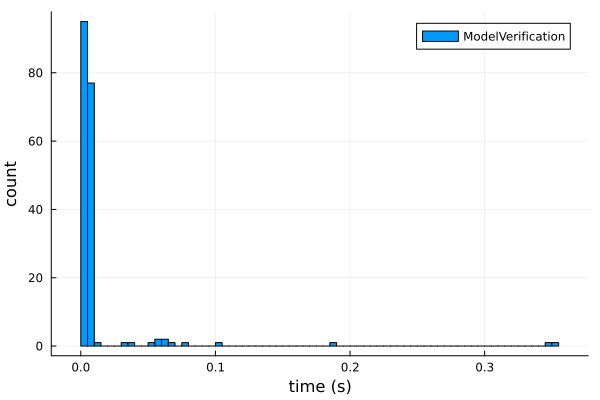

In [19]:
cr_df = DataFrame(CSV.File("./crown_result.csv", header=true))
cr_df[mv_df.time .> 116, :time] .= 116
t = histogram(cr_df.time, bins=100, label="ModelVerification")
xlabel!("time (s)")
ylabel!("count")
display(t)

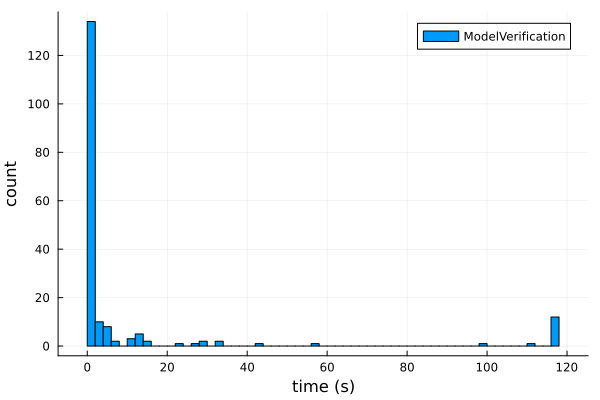

In [20]:
mv_df = DataFrame(CSV.File("./result.csv", header=true))
mv_df[mv_df.time .> 116, :time] .= 116
t = histogram(mv_df.time, bins=100, label="ModelVerification")
xlabel!("time (s)")
ylabel!("count")
display(t)

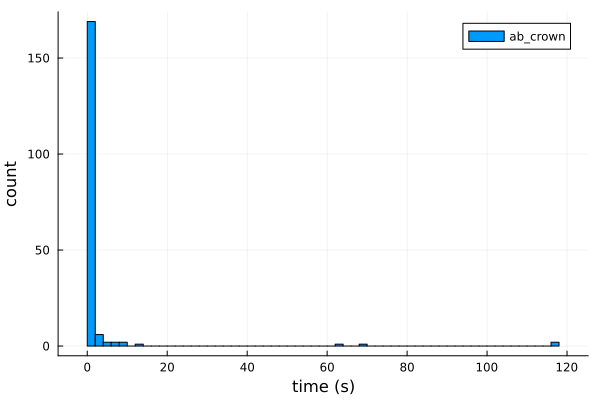

In [21]:
ab_df = DataFrame(CSV.File("./abcrown_result.csv", header=true))
ab_df[!,:value] = convert.(String15, ab_df[!,:value])
ab_df[ab_df.value .== "safe", :value] .= "holds"
ab_df[ab_df.value .== "unsafe", :value] .= "violated"
t = histogram(ab_df.time, bins=100, label="ab_crown")
xlabel!("time (s)")
ylabel!("count")
display(t)

In [22]:
println(sum(cr_df.value .== "holds"))
println(sum(cr_df.value .== "violated"))
println(sum(cr_df.value .== "unknown"))

171
15
0


In [11]:
println(sum(ab_df.value .== "holds"))
println(sum(ab_df.value .== "violated"))
println(sum(ab_df.value .== "unknown"))

139
45
2


In [12]:
println(sum(mv_df.value .== "holds"))
println(sum(mv_df.value .== "violated"))
println(sum(mv_df.value .== "unknown"))

129
45
12


In [13]:
[mv_df[mv_df.value .!= ab_df.value, :value], ab_df[mv_df.value .!= ab_df.value, :value]]

2-element Vector{AbstractVector{String15}}:
 ["unknown", "unknown", "unknown", "unknown", "violated", "unknown", "unknown", "unknown", "unknown", "unknown", "unknown", "unknown"]
 ["holds", "holds", "holds", "holds", "unknown", "holds", "holds", "holds", "holds", "holds", "violated", "holds"]